# PLAsTiCC time series classification
This is a ML code that performs classification of the time series from the Photometric LSST Astronomical Time-Series Classification Challenge (PLAsTiCC; https://www.kaggle.com/c/PLAsTiCC-2018). A sample representation of the data is provided after loading the data.

Labels are provided for the training set.

The steps are the following: <br>
1. Import libraries and sample
2. Split sub-samples (training, validation, testing)
3. Fit with various classifier and check performance
4. Compare various classifiers in testing sample

The alternative classifiers provide first guesses on the expected accuracy

## Loading Data

In [140]:
# Importing Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets, utils, metrics
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter('ignore')

In [141]:
path_to_data = "/data/deep_learning/database_PLAsTiCC/training_data_v1"

In [171]:
import glob
files = glob.glob(path_to_data + "/*.npy")


# > Loading series / labels:
# <indexed as ID array>

IDs   = []
# ID number (without "id-")
bands = []
# band name (without "band-") [0 .. 5]

series = []
labels = []

data_uneven = []
# <[samples , len(data) , channel , band ]>
    # NOTE: the arrays in data can have different lengths


# restore: for i in range(len(files)):
for i in range(10):

    tmp = np.load(files[i])

    IDs.append(files[i].split("/")[-1].split("_")[0].strip("id-"))
    bands.append(int(files[i].split("/")[-1].split("_")[1].strip("band-")))

    band = bands[-1]
    # current band
    
    series.append(tmp)
    labels.append(files[i].split("/")[-1].split("-")[-1].strip(".npy"))

    
    # > Loading single data files:
    #
    # Data format:
    #
    # Modified Juilian Date, Flux, err_Flux, Detected (flag)

    MJD = series[-1][:,0]
    # Modified Julian Date
    
    F = series[-1][:,1]
    # flux
    
    F_err = series[-1][:,2]
    # flux error
    

    # > Converting data into arrays of "steps" (or "differences")
    #
    # Here we follow Aguirre et al. (2018, MNRAS) - see their Figure 7, who define:
    #
    #   [0, (T_1 - T_0), ..,(T_N - T_N-1)]
    #   [0, (M_1 - M_0), ..,(M_N - M_N-1)]
    #
    # with the variation that we deal with fluxes (and not magnitudes), and drop the first bin.
    # We will therefore calculate:
    #
    #   [(T_1 - T_0), ..,(T_N - T_N-1)]
    #   [(F_1 / F_0), ..,(F_N / F_N-1)]
    
    # This is done in a three-step process:
    #
    # 1- Create another array where we have removed the last element, moved everything
    #    in position to the right, and insert the same first value at the beginning

    MJD2sub = np.insert(MJD[0:-1], 0, MJD[0])

    F2sub = np.insert(F[0:-1], 0, F[0])

    # 2- Subtract the two arrays to get the element-wise differences

    MJD_diff = MJD - MJD2sub

    F_diff = F / F2sub
   
    # 3- Drop the first bin (and convert to nparray)
    # NOTE: Can be the first bin a useful anchor point, and shall it be kept instead?
    
    MJD_diff = np.array(MJD_diff[1:])
    F_diff   = np.array(F_diff[1:])
    
    
    # > Organizing data in a 2D matrix with shape [ len(arrays) , channels (=2) ]
    
    data_i = np.zeros((2,len(MJD_diff),6))
    # data element for series i
    # 2 = number of channels
    # 6 = number of bands
 
    data_i[0,:,band] = MJD_diff
    data_i[1,:,band] = F_diff
    
    data_uneven.append(data_i)
    # NOTE: the arrays in data can have different lengths

    
series = np.array(series)


# > Padding data to match maximum number of points among all data series:

N_max = ( max(len(d) for d in data_uneven[1]) )
# maximum number of data points among all data series

data = np.zeros( (len(data_uneven) , 2 , N_max , 6 ) )
# creating "canvas" array to be filled by loaded data (leaving 0s to pad missing data)

for i in range(len(data_uneven)):
    
    data[i,:data_uneven[i].shape[0],:data_uneven[i].shape[1],:] = data_uneven[i]
    # filling data only within the size of the matrix of actual data, leaving the rest set to 0
    
    
# Shuffle the samples
shuffled_indexes = np.arange(len(series))
np.random.shuffle(shuffled_indexes)


# To reduce the sample size (for testing purposes):
# remove: shuffled_indexes = shuffled_indexes[0:1000]
# remove: n_samples = len(shuffled_indexes)

data = data[shuffled_indexes]
labels = list(np.array(labels)[shuffled_indexes])

print(data.shape)

print(data[0])


(10, 2, 57, 6)
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    1.39560000e+01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    2.98280000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    1.20101000e+01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    2.97900000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    9.97210000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    2.99200000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    2.99220000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    1.09850000e+01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    2.96590000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

## Display some examples of data series


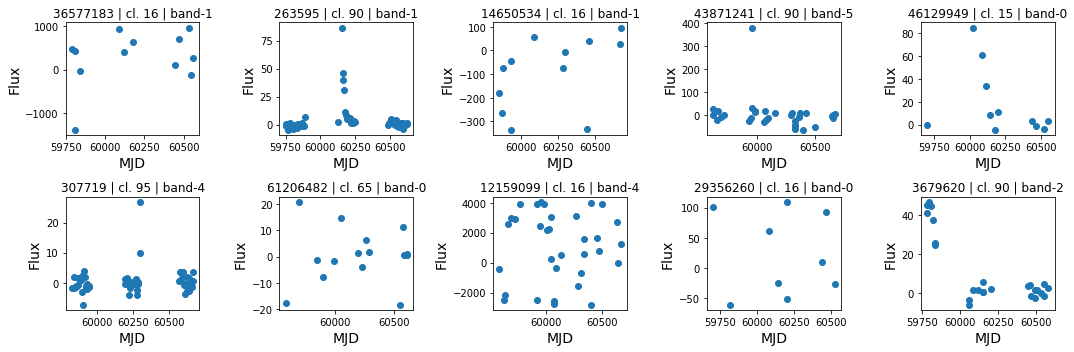

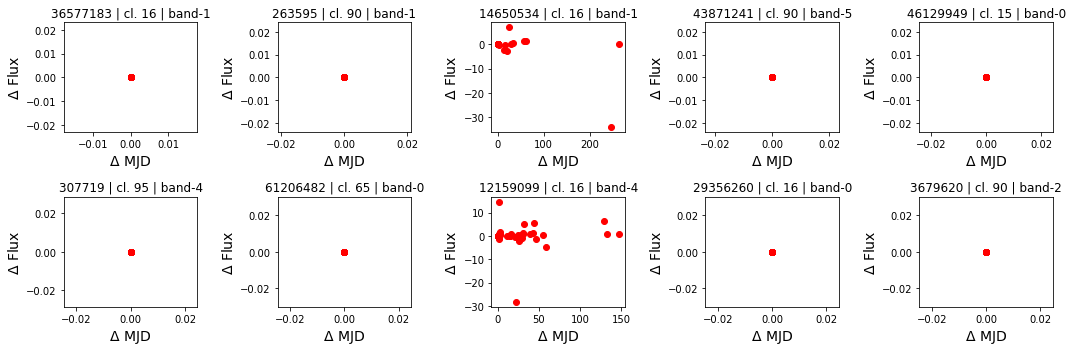

In [169]:
series_and_labels = list(zip(series, labels))

# > Original data

bands_display = []
# contains the bands for the first <10> display objects
# NOTE: necessary because the formatted data contain all bands in a different sorting order

fig = plt.figure(figsize=(15,5))
for index, (serie, label) in enumerate(series_and_labels[:10]):
    plt.subplot(2, 5, index + 1)

    plt.xlabel('MJD',  fontsize=14)
    plt.ylabel('Flux', fontsize=14)
    
    plt.tight_layout()
    
    MJD = serie[:,0]
    # Modified Julian Date
     
    F = serie[:,1]
    # flux
    
    plt.scatter(MJD,F)
    plt.title(IDs[index] + " | cl. " + labels[index] + " | band-" + str(bands[index]))
    
    bands_display.append(bands[index])

# > Formatted data
    
fig = plt.figure(figsize=(15,5))
for index, (serie, label) in enumerate(series_and_labels[:10]):
    plt.subplot(2, 5, index + 1)

    plt.xlabel('$\Delta$ MJD',  fontsize=14)
    plt.ylabel('$\Delta$ Flux', fontsize=14)
    
    plt.tight_layout()
    
    MJD_diff_band = data[index,0,:,bands_display[index]]
    F_diff_band   = data[index,1,:,bands_display[index]]
        
    plt.scatter(MJD_diff_band,F_diff_band, color='red')
    plt.title(IDs[index] + " | cl. " + labels[index] + " | band-" + str(bands_display[index]))


In [ ]:
del series
# purging memory from a variable not used anymore

In [ ]:
# Here we are going to use astropy to read fits images and convert them into 
# similar format matrices
# you can also use np.matrix.flatten to flatten a matrix into a single line
import glob
files = glob.glob(path_to_data + "/*.npy")


# not working: galaxies = np.array([np.load(i) for i in files])
# not working: images have different sizes


# Looking for median x,y pixel size in the first 10 entries:
# NOTE: make sure that the first 10 dimensions are not peculiar
median_files = files[0:10]

size_x = []
size_y = []

for i in range(len(median_files)):
    tmp = np.load(files[i])
    size_x.append(tmp.shape[0])
    size_y.append(tmp.shape[1])

median_size_x = int(np.median(size_x))
median_size_y = int(np.median(size_y))


# Loading only images / labels corresponding to images of expected size:

galaxies = []
labels   = []

for i in range(len(files)):
    tmp = np.load(files[i])
    if( (tmp.shape[0] == median_size_x) and (tmp.shape[1] == median_size_y) ):
        galaxies.append(tmp)
        labels.append(files[i].split("/")[-1].split("_")[0])

galaxies = np.array(galaxies)


# Display some example images of galaxies
images_and_labels = list(zip(galaxies, labels))


fig = plt.figure(figsize=(10,5))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, vmin=np.min(image), vmax=0.25*np.max(image), interpolation='nearest')
    plt.title(label)
    

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(galaxies)
data = galaxies.reshape((n_samples, -1))


# Normalize values to maximum (and setting low values to 0)
for i in range(len(data)):

    # To convert images to log scale:
    #
    #data[i] = (data[i] + (1+1e-5)*np.abs(np.min(data[i])))
    # adding costant to avoid negative values
    # NOTE: adding additional tiny costant to avoid 0s which can cause the log10 to get crazy
    #
    #data[i] = np.log10(data[i])
    # changing dynamic range to prevent point-like sources and bulges from dominating
    #
    #data[i] = (data[i] + np.abs(np.min(data[i])))
    # adding costant again to avoid negative values because log10 can generate negative values
    
    data[i] = (data[i] + np.abs(np.min(data[i])))
    # adding costant to avoid negative values
    
    data[i] = data[i] / np.max(data[i])
    # normalizing
    # NOTE: now data ranges between 0 and 1
    
# Shuffle the samples
shuffled_indexes = np.arange(len(galaxies))
np.random.shuffle(shuffled_indexes)


# To reduce the sample size (for testing purposes):
# remove: shuffled_indexes = shuffled_indexes[0:1000]
# remove: n_samples = len(shuffled_indexes)

data = data[shuffled_indexes]
labels = list(np.array(labels)[shuffled_indexes])

del galaxies
# purging memory from a variable not used anymore

In [ ]:
# Splitting in training, validation, and test samples:
data_train = data[:8 * n_samples // 10] # i.e. 80% training
labels_train = labels[:8 * n_samples // 10]

data_valid = data[8 * n_samples // 10:9 * n_samples // 10] # i.e. 10% validation (80->90%)
labels_valid = labels[8 * n_samples // 10:9 * n_samples // 10]

data_test = data[9 * n_samples // 10:] # i.e. 10% testing (90->100%)
labels_test = labels[9 * n_samples // 10:]

n_train_spiral = len([x for x in labels_train if x == 'spiral'])
n_train_ellipt = len([x for x in labels_train if x == 'ellipt'])

n_valid_spiral = len([x for x in labels_valid if x == 'spiral'])
n_valid_ellipt = len([x for x in labels_valid if x == 'ellipt'])

n_test_spiral = len([x for x in labels_test if x == 'spiral'])
n_test_ellipt = len([x for x in labels_test if x == 'ellipt'])

print("Sample Summary")
print("________________________")
print("Total images     | %5s" % len(data))
print("-----------------|------")
print(" '-> Training    | %5s" % len(data_train))
print("      '-> spiral | %5s (%.1f%%)" % (n_train_spiral , (n_train_spiral/len(data_train)*100.)))
print("      '-> ellipt | %5s (%.1f%%)" % (n_train_ellipt , (n_train_ellipt/len(data_train)*100.)))
print("-----------------|------")
print(" '-> Validation  | %5s" % len(data_valid))
print("      '-> spiral | %5s (%.1f%%)" % (n_valid_spiral , (n_valid_spiral/len(data_valid)*100.)))
print("      '-> ellipt | %5s (%.1f%%)" % (n_valid_ellipt , (n_valid_ellipt/len(data_valid)*100.)))
print("-----------------|------")
print(" '-> Test        | %5s" % len(data_test))
print("      '-> spiral | %5s (%.1f%%)" % (n_test_spiral , (n_test_spiral/len(data_test)*100.)))
print("      '-> ellipt | %5s (%.1f%%)" % (n_test_ellipt , (n_test_ellipt/len(data_test)*100.)))

print('')
print('Compare these values with the accuracy of each classifier')
print('If accuracies are similar to the demographics, the classifier is only mirroring the data')

## 1) Using scikit-learn / SVM classifier
Classical Support Vector Machines classifier

NOTE: The non-linear kernel is extremely slow

In [ ]:
# Classifier
model_svc = LinearSVC()
#model_svc = NuSVC()
model_svc.fit(data_train, labels_train)

# Comparisong with prediction
predicted = model_svc.predict(data_valid)

print("Classification report for %s:\n%s\n"
      % (model_svc, metrics.classification_report(labels_valid, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_valid, predicted))

## 2) Using scikit-learn / LogisticRegression classifier

In [ ]:
# Classifier
model_lrc = LogisticRegression()
model_lrc.fit(data_train, labels_train)

# Comparisong with prediction
predicted = model_svc.predict(data_valid)

print("Classification report for %s:\n%s\n"
      % (model_lrc, metrics.classification_report(labels_valid, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_valid, predicted))

## 3) Using scikit-learn / Multilayer perceptron classifier
A simple Neural Network (Multilayer perceptron) classifier.

In [ ]:
# Classifier
model_MLP = MLPClassifier()
model_MLP.fit(data_train, labels_train)

# Comparisong with prediction
predicted = model_MLP.predict(data_valid)

print("Classification report for %s:\n%s\n"
      % (model_MLP, metrics.classification_report(labels_valid, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_valid, predicted))

## 4) Using scikit learn / Random Forests
A scikit-learn bagging classifier.

In [ ]:
# Classifier
model_RF = RandomForestClassifier()
model_RF.fit(data_train, labels_train)

# Comparisong with prediction
predicted = model_RF.predict(data_valid)

print("Classification report for %s:\n%s\n"
      % (model_RF, metrics.classification_report(labels_valid, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_valid, predicted))

## 5) Building a Keras Neural Network classifier


In [ ]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Convolution1D
from keras.layers import Convolution2D
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Dropout

from tensorflow.contrib.layers import maxout

from keras.utils import np_utils
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [ ]:
num_pixels = data_train.shape[1] 

# It is good practice to use a one hot encoding 
# of the class values (ellip, spiral), to tranform
# the vector of class integers into a binary matrix.
int_enc = LabelEncoder()
labels_train_int = int_enc.fit_transform(labels_train)
labels_valid_int = int_enc.fit_transform(labels_valid)
labels_test_int = int_enc.fit_transform(labels_test)

oh_enc = OneHotEncoder(sparse=False)
labels_train_int = labels_train_int.reshape(len(labels_train_int), 1)
labels_train_ohe = oh_enc.fit_transform(labels_train_int)
labels_valid_int = labels_valid_int.reshape(len(labels_valid_int), 1)
labels_valid_ohe = oh_enc.fit_transform(labels_valid_int)
labels_test_int = labels_test_int.reshape(len(labels_test_int), 1)
labels_test_ohe = oh_enc.fit_transform(labels_test_int)

# uniques, labels_valid = np.unique(labels_valid, return_inverse=True)
labels_train_cat = np_utils.to_categorical(labels_train_int)
labels_valid_cat = np_utils.to_categorical(labels_valid_int)
labels_test_cat  = np_utils.to_categorical(labels_test_int)

num_classes = labels_valid_ohe.shape[1]

In [ ]:
# Formatting data for convolutional layer:

n_pixels         = int(np.sqrt(num_pixels))
n_train_galaxies = data_train.shape[0]
n_valid_galaxies = data_valid.shape[0]
n_test_galaxies  = data_test.shape[0]

data_train_3D = data_train.reshape(n_train_galaxies, n_pixels, n_pixels)
data_train_4D = np.expand_dims(data_train_3D, axis=3)

data_valid_3D = data_valid.reshape(n_valid_galaxies, n_pixels, n_pixels)
data_valid_4D = np.expand_dims(data_valid_3D, axis=3)

data_test_3D  = data_test.reshape(n_test_galaxies, n_pixels, n_pixels)
data_test_4D  = np.expand_dims(data_test_3D, axis=3)
# data_* have now dimension: (samples, channels, rows, cols)

labels_train_int_4D = np.expand_dims(labels_train_int   , axis=0)
labels_train_int_4D = np.expand_dims(labels_train_int_4D, axis=0)
labels_valid_int_4D = np.expand_dims(labels_valid_int   , axis=0)
labels_valid_int_4D = np.expand_dims(labels_valid_int_4D, axis=0)
labels_test_int_4D  = np.expand_dims(labels_test_int    , axis=0)
labels_test_int_4D  = np.expand_dims(labels_test_int_4D , axis=0)

print("Data/Label formats for convolutional layers:")

print("Train      4D data format (n_samples,size_x, size_y, n_channels) | ", data_train_4D.shape)
print("Validation 4D data format (n_samples,size_x, size_y, n_channels) | ", data_valid_4D.shape)
print("Test       4D data format (n_samples,size_x, size_y, n_channels) | ", data_test_4D.shape)

print("Train      4D label format (?, ?, n_samples, n_channels)         | ", labels_train_int_4D.shape)
print("Validation 4D label format (?, ?, n_samples, n_channels)         | ", labels_valid_int_4D.shape)
print("Test       4D label format (?, ?, n_samples, n_channels)         | ", labels_test_int_4D.shape)

#print(labels_train_cat.shape)
#print(labels_valid_cat.shape)

### Flattened 1D layers
With the same syntax it is also possible to implement the convolutional layers (commented out), but one has to change the shape of the imput

In [ ]:
# Define the model
def baseline_model():
    # create model
    sgd = optimizers.SGD(lr=0.1)
    model_1D = Sequential()
    #model_1D.add(Convolution2D(64, kernel_size=(8,8), strides=(1,1), padding='same',
    #                                          activation='sigmoid', input_shape=(n_pixels,n_pixels,1)))
    #model_1D.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    #model_1D.add(Flatten())#input_shape=(64, 64)))
    model_1D.add(Dense(num_pixels // 3, input_dim=num_pixels, kernel_initializer='normal',activation='relu'))
    model_1D.add(Dropout(0.2))
    model_1D.add(Dense(num_classes, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model_1D.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
    return model_1D

# Build the model
model_1D = baseline_model()

In [ ]:
# Fit the model

# 1D run:
history_1D = model_1D.fit(data_train, labels_train_ohe, validation_data=(data_valid, labels_valid_ohe), 
                                            epochs=15, batch_size=500, verbose=2)

# Convolutional layer run:
#history = model_1D.fit(data_train_4D, labels_train_cat, validation_data=(data_valid_4D, labels_valid_cat), 
#                                            epochs=5, batch_size=500, verbose=2)

In [ ]:
# > Model evolution:
plt.plot(history_1D.history['loss'])
plt.plot(history_1D.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


# > Comparison with predictions:
labels_pred_float_1D = model_1D.predict(data_test)

labels_pred_1D = int_enc.inverse_transform(labels_pred_float_1D.argmax(1))
# reversing one hot encoding

print("Classification report for %s:\n%s\n"
      % (model_1D, metrics.classification_report(labels_test, labels_pred_1D)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_1D))


### Convolutional 2D layers

Not working with 'mean_squared_error' loss 

Loss function gets stuck when using 'softmax' activation

In [ ]:
# Best so far (97% accuracy on test):
#
#model_Conv = keras.Sequential([
#                          keras.layers.Conv2D(8, kernel_size=(4,4), strides=(2,2), padding='same',
#                                              activation=tf.nn.relu, input_shape=(n_pixels,n_pixels,1)),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          keras.layers.Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same',
#                                              activation=tf.nn.relu),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          keras.layers.Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same',
#                                              activation=tf.nn.relu),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          #keras.layers.Dropout(0.3),
#                          keras.layers.Flatten(),
#                          keras.layers.Dense(10, activation=tf.nn.sigmoid),
#                          keras.layers.Dropout(0.3),
#                          keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
#                          ])

model_Conv = keras.Sequential([
                          keras.layers.Conv2D(8, kernel_size=(4,4), strides=(1,1), padding='same',
                                              activation=tf.nn.relu, input_shape=(n_pixels,n_pixels,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          keras.layers.Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same',
                                              activation=tf.nn.relu),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          keras.layers.Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same',
                                              activation=tf.nn.relu),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          #keras.layers.Dropout(0.3),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10, activation=tf.nn.sigmoid),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
                          ])

model_Conv.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history_Conv = model_Conv.fit(data_train_4D, labels_train_int, validation_data=(data_valid_4D, labels_valid_int),
                    epochs=30, batch_size=100, verbose=2)

In [ ]:
# > Model evolution:
plt.plot(history_Conv.history['loss'])
plt.plot(history_Conv.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# > Comparison with predictions:
labels_pred_float_Conv = model_Conv.predict(data_test_4D)

labels_pred_Conv = int_enc.inverse_transform(labels_pred_float_Conv.argmax(1))
# reversing one hot encoding


print("Classification report for %s:\n%s\n"
      % (model_Conv, metrics.classification_report(labels_test, labels_pred_Conv)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_Conv))


# > Plotting a few misclassified images (wrong labels):

print('Examples of misclassified images:')

indexes_wrong = np.nonzero(labels_pred_Conv != labels_test)
# equivalent: indexes_wrong = [labels_pred_Conv != labels_test]
# indexes of misclassified objects <indexed within range(data_test) or range(labels_pred_*)>

labels_pred_int_Conv = labels_pred_float_Conv.argmax(1)

data_test_wrong            = data_test[indexes_wrong]
labels_test_int_wrong      = labels_test_int[indexes_wrong]
labels_pred_int_Conv_wrong = labels_pred_int_Conv[indexes_wrong]


fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=0.25,wspace=0.05)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    image_wrong = (data_test_wrong[i].reshape(n_pixels,n_pixels))
    plt.imshow(image_wrong, cmap=plt.cm.gray_r, vmin=np.min(image_wrong), vmax=0.25*np.max(image_wrong), interpolation='nearest')
    plt.title('label = %s | pred = %s' % (labels_test_int_wrong[i][0] , labels_pred_int_Conv_wrong[i]))



https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

## 5) Using Tensorflow
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network_raw.ipynb

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network.ipynb

## Final check 
Using the test sample for a final check of the various algorithms used above. 

Checking if their performance is as good as it is reported in the validation process.

In [ ]:
print("====================================================================================")
# Predictions for SVM:
predicted = model_svc.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_svc, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for LogisticRegression:
predicted = model_svc.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_lrc, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for MLP:
predicted = model_MLP.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_MLP, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for RandomForests:
predicted = model_RF.predict(data_test)
print("Classification report for %s:\n%s\n"
      % (model_RF, metrics.classification_report(labels_test, predicted)))
print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
print("====================================================================================")

# Predictions for Keras 1D Neural Network:
labels_pred_float_1D = model_1D.predict(data_test)
labels_pred_1D = int_enc.inverse_transform(labels_pred_float_1D.argmax(1))
print("Classification report for %s:\n%s\n"
      % (model_1D, metrics.classification_report(labels_test, labels_pred_1D)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_1D))
print("====================================================================================")

# Predictions for Keras Convolutional Neural Network:
labels_pred_float_Conv = model_Conv.predict(data_test_4D)
labels_pred_Conv = int_enc.inverse_transform(labels_pred_float_Conv.argmax(1))
print("Classification report for %s:\n%s\n"
      % (model_Conv, metrics.classification_report(labels_test, labels_pred_Conv)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_Conv))
print("====================================================================================")

# Saving the trained models
Using pickle we can save the trained models to use them in a later time w/o the need to re-train them.

In [ ]:
import pickle
import os

# saving the models to disk
folder_saved = "saved_models/v1"

model_labels = ['SVC','LogReg','MLP','RandFor','Ker_1D','Ker_Conv']
models = ['model_SVC','model_LR','model_MLP','model_RF','model_1D','model_Conv']

if not os.path.exists(folder_saved):
    os.makedirs(folder_saved)
    
for modstr,model in zip(model_labels,models):
    pickle.dump(model, open(folder_saved+'/galaxy_classification_SDSS_v1_'+modstr+'.sav', 'wb'))


# To load the models at a later time:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)